# Visualizing COGs

_by Alex Berndt 13 Dec 2021_

This notebook contains the content from [Development Seed's tiltiler tutorial](https://developmentseed.org/titiler/examples/notebooks/Working_with_STAC/).

In [3]:
import os
import json
import base64
import httpx
import datetime
import itertools
import urllib.parse

from io import BytesIO
from functools import partial
from concurrent import futures

from tqdm.notebook import tqdm

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from folium import Map, TileLayer, GeoJson

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Endpoint variables
titiler_endpoint = "https://titiler.xyz"  # Developmentseed Demo endpoint. Please be kind.
stac_endpoint = "https://earth-search.aws.element84.com/v0/search"

In [6]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [7.2, 47.0],
                [7.5, 47.0],
                [7.5, 47.8],
                [7.2, 47.8],
                [7.2, 47.0],
            ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

m = Map(
    tiles="OpenStreetMap",
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=11
)

geo_json = GeoJson(data=geojson)
geo_json.add_to(m)
m

In [7]:
start = datetime.datetime.strptime("2019-08-01", "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
end = datetime.datetime.strptime("2019-12-11", "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")

# POST body
query = {
    "collections": ["sentinel-s2-l2a-cogs"],
    "datetime": f"{start}/{end}",
    "query": {
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    "intersects": geojson["features"][0]["geometry"],
    "limit": 100,
    "fields": {
      'include': ['id', 'properties.datetime', 'properties.eo:cloud_cover'],  # This will limit the size of returned body
      'exclude': ['assets', 'links']  # This will limit the size of returned body
    }
}

# POST Headers
headers = {
    "Content-Type": "application/json",
    "Accept-Encoding": "gzip",
    "Accept": "application/geo+json",
}

data = httpx.post(stac_endpoint, headers=headers, json=query).json()
print("Results context:")
print(data["context"])
print()
print("Example of item:")
print(json.dumps(data["features"][0], indent=4))

sceneid = [f["id"] for f in data["features"]]
cloudcover = [f["properties"]["eo:cloud_cover"] for f in data["features"]]
dates = [f["properties"]["datetime"][0:10] for f in data["features"]]

Results context:
{'page': 1, 'limit': 100, 'matched': 8, 'returned': 8}

Example of item:
{
    "bbox": [
        6.327940566386946,
        46.83565300363223,
        7.816635152887526,
        47.847362016092674
    ],
    "geometry": {
        "coordinates": [
            [
                [
                    6.3772930240597825,
                    46.83565300363223
                ],
                [
                    6.327940566386946,
                    47.82258645001515
                ],
                [
                    7.794341834105548,
                    47.847362016092674
                ],
                [
                    7.816635152887526,
                    46.8595919448329
                ],
                [
                    6.3772930240597825,
                    46.83565300363223
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "S2A_32TLT_20190917_0_L2A",
    "collection": "sentinel-s2-l2a-cogs",
    "type": "

In [8]:
m = Map(
    tiles="OpenStreetMap",
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=8
)

geo_json = GeoJson(
    data=data,
    style_function=lambda x: {
        'opacity': 1, 'dashArray': '1', 'fillOpacity': 0, 'weight': 1
    },
)
geo_json.add_to(m)
m

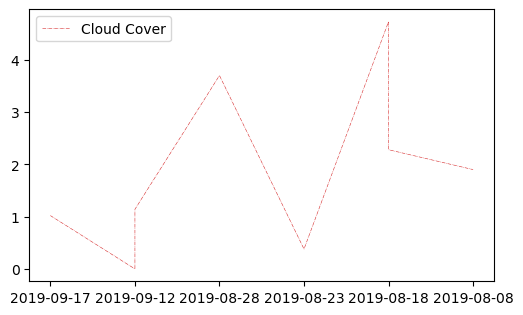

In [9]:
fig = plt.figure(dpi=100)
fig.autofmt_xdate()
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates, cloudcover, label="Cloud Cover", color="tab:red", linewidth=0.4, linestyle="-.")

ax.legend()

In [10]:
url_template = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{id}"


In [ ]:
# Get Tile URL
r = httpx.get(
    f"{titiler_endpoint}/stac/tilejson.json",
    params = (
        ("url", url_template.format(id=sceneid[0])),
        # Simple RGB combination (True Color)
        ("assets", "B04"),
        ("assets", "B03"),
        ("assets", "B02"),
        ("color_formula", "Gamma RGB 3.5 Saturation 1.7 Sigmoidal RGB 15 0.35"),  # We use a rio-color formula to make the tiles look nice
        ("minzoom", 8),  # By default titiler will use 0
        ("maxzoom", 14), # By default titiler will use 24
    )
).json()
print(r)

m = Map(
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=10
)

tiles = TileLayer(
    tiles=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1,
    attr="Digital Earth Africa"
)
tiles.add_to(m)
m